In [1]:
!conda env list

# conda environments:
#
base                     /data/anaconda3
                         /home/student/miniconda3
                      *  /home/student/miniconda3/envs/hw1_env
                         /home/student/miniconda3/envs/hw1_test



In [2]:
!which python

/home/student/miniconda3/envs/hw1_env/bin/python


In [2]:
import sys
print(sys.executable)

/home/student/miniconda3/envs/hw1_env/bin/python


In [3]:
import torch

In [5]:
## notebook madness
## original kernel uses correct python install most of the time, wrong kernel the other half
## sklearn was also not installed in correct env

In [6]:
!conda list

# packages in environment at /home/student/miniconda3/envs/hw1_env:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
anyio                     3.5.0                    pypi_0    pypi
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py38h7f8727e_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
attrs                     21.4.0             pyhd3eb1b0_0  
babel                     2.10.1                   pypi_0    pypi
backcall                  0.2.0              pyhd3eb1b0_0  
beautifulsoup4            4.11.1           py38h06a4308_0  
blas                      1.0                         mkl  
bleach                    5.0.0                    pypi_0    pypi
brotlipy                  0.7.0           py38h27cfd23_1003  
bzip2                     1.0.8                h7b6447c_0  
ca-

In [1]:
import torch
import torch.nn as nn

from torch.optim import Adam


In [2]:
class net(nn.Module):
    def __init__(self, size, n_1, n_2,n_3):
        super(net, self).__init__()
        
        self.l1 = nn.Linear(size, n_1)
        self.l2 = nn.Linear(n_1, n_2)
        self.l3 = nn.Linear(n_2, n_3)
        self.l4 = nn.Linear(n_3,1)
        
        #self.drop = nn.Dropout(p=d)
        self.act = nn.ReLU()
        self.soft = nn.Sigmoid()
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(self.act(x))
        x = self.l3(self.act(x))
        x = self.l4(self.act(x))
        
        return self.soft(x)

In [114]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

In [4]:
data_list = os.listdir('data/train')

In [5]:
df_list = []
for i in data_list:
    df_temp = pd.read_csv("data/train/"+i,sep='|')
    df_list.append(df_temp)

In [6]:
len(df_list)

20000

In [7]:
def clip_df(df, label='SepsisLabel'):
    df = df.drop(labels=['Unit1', 'Unit2','EtCO2','Bilirubin_direct','TroponinI','Fibrinogen'], axis=1)
    index = df.loc[df[label] == 1].index
    if len(index) == 0:
        return df
    else:
        return df.loc[: index[0]]

In [8]:
new_df_list = []
for df in df_list:
    df_new = clip_df(df)
    #print(df_new)
    new_df_list.append(df_new)
    #break

In [9]:
values_dict = {}
#Age_list = []

for df in new_df_list:
    means = df.mean().dropna().to_dict()
    Age = means['Age']
    Gender = means['Gender']
    for column in means.keys():    
        val = means[column]
        if Gender not in values_dict.keys():
            values_dict[Gender] = {} 
        if column not in values_dict[Gender].keys():
            values_dict[Gender][column] = []
        values_dict[Gender][column].append((Age,val))

In [10]:
coef = {}
for g in values_dict:
    coef[g] = {}
    for key,vals in values_dict[g].items():
        X = np.array([x[0] for x in vals])
        y = np.array([x[1] for x in vals])
        reg = LinearRegression().fit(X.reshape(-1,1), y)
        coef[g][key] = [reg.coef_[0],reg.intercept_]

In [11]:
y = []
X = []
#Z = 0
for df in new_df_list:
    label = df.iloc[-1]['SepsisLabel']
    means = df.mean().to_dict()
    
    df_nu = (1-df.isna().mean())
    df_nu = df_nu.drop(labels=['Age', 'Gender','HospAdmTime','ICULOS','SepsisLabel'])
    
    for key in means.keys():
        if np.isnan(means[key]):
            means[key] = coef[means['Gender']][key][0]*means['Age'] + coef[means['Gender']][key][1]
        
    y.append(label)
    means.pop('SepsisLabel',None)
    means_list = list(means.values())
    means_list.extend(list(df_nu))
    X.append(means_list)

In [22]:
x = torch.Tensor(X)
y = torch.Tensor(y)

data_num = x.shape[0]
feat_num = x.shape[1]

In [63]:
l1 = 54
l2 = 50
l3 = 31
#d = 0.1145247638880034

In [25]:
data_list_test = os.listdir('data/test')

df_list_test = []
for i in data_list_test:
    df_temp = pd.read_csv("data/test/"+i,sep='|')
    df_list_test.append(df_temp)
    

new_df_list_test = []
for df in df_list_test:
    df_new = clip_df(df)
    new_df_list_test.append(df_new)
    
    
y_test = []
X_test = []
#Z = 0
for df in new_df_list_test:
    label = df.iloc[-1]['SepsisLabel']
    means = df.mean().to_dict()
    
    df_nu = (1-df.isna().mean())
    df_nu = df_nu.drop(labels=['Age', 'Gender','HospAdmTime','ICULOS','SepsisLabel'])
    
    for key in means.keys():
        if np.isnan(means[key]):
            means[key] = coef[means['Gender']][key][0]*means['Age'] + coef[means['Gender']][key][1]
        
    y_test.append(label)
    means.pop('SepsisLabel',None)
    means_list = list(means.values())
    means_list.extend(list(df_nu))
    X_test.append(means_list)

In [26]:
x_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

data_num = x_test.shape[0]
feat_num = x_test.shape[1]

In [70]:
net_log = net(feat_num, l1, l2, l3)
opti = Adam(net_log.parameters(), lr=0.0001)
loss = nn.BCELoss()

In [71]:
plot_list_loss_4 = []
plot_list_f1_4 = []
for i in range(100):
    p = np.arange(20000)
    np.random.shuffle(p)
    loss_list = []
    for t in range(int(data_num/50)):
        indexes = p[t*50:(t+1)*50]
        y_pred = net_log(x[indexes])
        
        ls = loss(torch.squeeze(y_pred), y[indexes])
        ls.backward()
        
        loss_list.append(ls.item())
        
        opti.step()
        net_log.zero_grad()
        opti.zero_grad()
    
    plot_list_loss_4.append(np.mean(loss_list))
    
    y_pred_test = net_log(x_test)
    y_test_pred = torch.squeeze(y_pred_test).detach().numpy()
    for i in range(len(y_test_pred)):
        if y_test_pred[i] >= 0.5:
            y_test_pred[i] = 1
        else:
            y_test_pred[i] = 0
    fi = f1_score(y_test.detach().numpy(), y_test_pred, average='binary')
    plot_list_f1_4.append(fi)

In [31]:
import matplotlib.pyplot as plt

In [32]:
xlabel = np.arange(100)

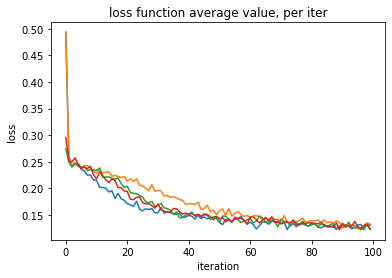

In [72]:
plt.plot(xlabel, plot_list_loss_1)
plt.plot(xlabel, plot_list_loss_2)
plt.plot(xlabel, plot_list_loss_3)
plt.plot(xlabel, plot_list_loss_4)

plt.title('loss function average value, per iter')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

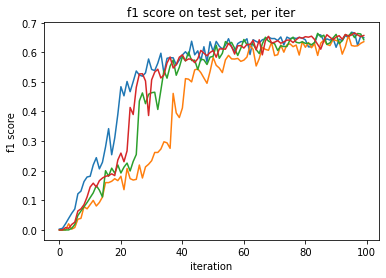

In [73]:
plt.plot(xlabel, plot_list_f1_1)
plt.plot(xlabel, plot_list_f1_2)
plt.plot(xlabel, plot_list_f1_3)
plt.plot(xlabel, plot_list_f1_4)

plt.title('f1 score on test set, per iter')
plt.xlabel('iteration')
plt.ylabel('f1 score')
plt.show()
plt.show()

In [23]:
print(x_test.shape)

torch.Size([10000, 64])


In [74]:
y_pred_test = net_log(x_test)

In [75]:
y_test_pred = torch.squeeze(y_pred_test).detach().numpy()

In [76]:
for i in range(len(y_test_pred)):
    if y_test_pred[i] >= 0.5:
        y_test_pred[i] = 1
    else:
        y_test_pred[i] = 0

In [77]:
f1_score(y_test.detach().numpy(), y_test_pred, average='macro')

0.8166567470588547

In [78]:
f1_score(y_test.detach().numpy(), y_test_pred, average='binary')

0.656763096168882

In [79]:
net_log.load_state_dict(dicti['params'])

<All keys matched successfully>

In [99]:
y_pred_test = net_log(x_test)

In [111]:
y_roc_test = y_pred_test.detach().numpy()
#y_roc_test = y_roc_test.reshape((1,-1))

In [112]:
y_test.detach().numpy().shape

(10000,)

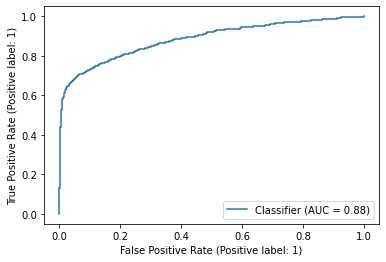

In [117]:
RocCurveDisplay.from_predictions(y_test.detach().numpy(), y_roc_test)
plt.show()

In [118]:
y_test_pred = torch.squeeze(y_pred_test).detach().numpy()

In [119]:
for i in range(len(y_test_pred)):
    if y_test_pred[i] >= 0.5:
        y_test_pred[i] = 1
    else:
        y_test_pred[i] = 0

In [120]:
f1_score(y_test.detach().numpy(), y_test_pred, average='macro')

0.8254339029063368

In [121]:
f1_score(y_test.detach().numpy(), y_test_pred, average='binary')

0.672566371681416

In [122]:
from sklearn.metrics import precision_score, recall_score

In [123]:
precision_score(y_test.detach().numpy(), y_test_pred)

0.8326693227091634

In [124]:
recall_score(y_test.detach().numpy(), y_test_pred)

0.5641025641025641

In [85]:
import csv
lis = []
with open('prediction.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        lis.append(row)
    

In [93]:
for i in range(len(lis)):
    if int(lis[i][1]) == 1:
        print(y_test_pred[i])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [29]:
print(x.shape, x_test.shape)

torch.Size([20000, 64]) torch.Size([10000, 64])


In [30]:
import optuna


In [80]:
dict_model = {}
def objective(trial):
    n1 = trial.suggest_int('layer 1', 20, 100)
    n2 = trial.suggest_int('layer 2', 10, n1)
    n3 = trial.suggest_int('layer 3', 2, n2)
    #drop = trial.suggest_float('drop chance', 0.02, 0.15)
    
    #learn = trial.suggest_float('learning rate', 0.00001, 0.0001)
    
    n_log = net(feat_num, n1, n2,n3)
    opti = Adam(n_log.parameters(), lr=0.0001)
    loss = nn.BCELoss()
    
    for i in range(100):
        p = np.arange(20000)
        np.random.shuffle(p)

        for t in range(int(data_num/50)):
            indexes = p[t*50:(t+1)*50]
            y_pred = n_log(x[indexes])

            ls = loss(torch.squeeze(y_pred), y[indexes])

            ls.backward()
            opti.step()
            n_log.zero_grad()
            opti.zero_grad()
    
    n_log.eval()
    y_pred_test = n_log(x_test)
    y_test_pred = torch.squeeze(y_pred_test).detach().numpy()
    for i in range(len(y_test_pred)):
        if y_test_pred[i] >= 0.5:
            y_test_pred[i] = 1
        else:
            y_test_pred[i] = 0
    dict_model[trial.number] = n_log
    return -f1_score(y_test.detach().numpy(), y_test_pred, average='binary')

In [81]:
study = optuna.create_study()
study.optimize(objective, n_trials = 100)

[I 2022-05-13 20:10:50,127] A new study created in memory with name: no-name-da31e280-5b83-443d-aa5d-67c2d40cf352
[I 2022-05-13 20:11:07,274] Trial 0 finished with value: -0.6661417322834644 and parameters: {'layer 1': 94, 'layer 2': 61, 'layer 3': 55}. Best is trial 0 with value: -0.6661417322834644.
[I 2022-05-13 20:11:25,118] Trial 1 finished with value: -0.6536267318663406 and parameters: {'layer 1': 99, 'layer 2': 92, 'layer 3': 39}. Best is trial 0 with value: -0.6661417322834644.
[I 2022-05-13 20:11:40,270] Trial 2 finished with value: -0.6629123089300081 and parameters: {'layer 1': 59, 'layer 2': 27, 'layer 3': 27}. Best is trial 0 with value: -0.6661417322834644.
[I 2022-05-13 20:11:55,815] Trial 3 finished with value: -0.6235489220563848 and parameters: {'layer 1': 60, 'layer 2': 58, 'layer 3': 16}. Best is trial 0 with value: -0.6661417322834644.
[I 2022-05-13 20:12:12,169] Trial 4 finished with value: -0.6530958439355387 and parameters: {'layer 1': 81, 'layer 2': 57, 'layer

In [82]:
study.best_params

{'layer 1': 54, 'layer 2': 50, 'layer 3': 31}

In [83]:
dict_model[28]

net(
  (l1): Linear(in_features=64, out_features=54, bias=True)
  (l2): Linear(in_features=54, out_features=50, bias=True)
  (l3): Linear(in_features=50, out_features=31, bias=True)
  (l4): Linear(in_features=31, out_features=1, bias=True)
  (act): ReLU()
  (soft): Sigmoid()
)

In [84]:
dict_to_save = {}
dict_to_save['hyper'] = study.best_params
dict_to_save['params'] = dict_model[28].state_dict()

In [85]:
torch.save(dict_to_save, 'model_relu.pth')

In [50]:
dicti = torch.load('model_relu2.pth')

In [51]:
dicti

{'hyper': {'layer 1': 54, 'layer 2': 50, 'layer 3': 31, 'size': 64},
 'params': OrderedDict([('l1.weight',
               tensor([[ 0.0349,  0.1055, -0.0766,  ...,  0.2133, -0.0110,  0.1184],
                       [ 0.1359,  0.0264,  0.0339,  ...,  0.3136,  0.1834,  0.1558],
                       [ 0.0840, -0.0107,  0.1282,  ...,  0.1395, -0.0352,  0.1893],
                       ...,
                       [-0.0556, -0.0275,  0.0460,  ..., -0.4087, -0.0889, -0.1221],
                       [ 0.1067, -0.0606,  0.1280,  ...,  0.2799,  0.1146,  0.2030],
                       [ 0.1087,  0.0024,  0.0372,  ...,  0.1636, -0.0596,  0.0382]])),
              ('l1.bias',
               tensor([-0.0476, -0.0757,  0.0502, -0.0437, -0.0222, -0.0960,  0.1033, -0.0670,
                        0.0947,  0.0646,  0.0441, -0.1076,  0.0552,  0.0661,  0.0765,  0.0608,
                        0.1445, -0.1203,  0.1301,  0.0654, -0.1198,  0.1358,  0.0695, -0.0307,
                       -0.0183, -0.0934, 

In [87]:
dicti['hyper']['size'] = feat_num
dicti['coef'] = coef

In [88]:
torch.save(dicti, 'model_relu2.pth')

In [73]:
study = optuna.create_study()
study.optimize(objective, n_trials = 100)

[I 2022-05-13 19:26:20,692] A new study created in memory with name: no-name-feff0049-7efc-486c-81e2-cedf721d805f
[I 2022-05-13 19:26:36,129] Trial 0 finished with value: -0.5470383275261324 and parameters: {'layer 1': 76, 'layer 2': 42, 'layer 3': 21}. Best is trial 0 with value: -0.5470383275261324.
[I 2022-05-13 19:26:51,018] Trial 1 finished with value: -0.4954462659380693 and parameters: {'layer 1': 52, 'layer 2': 32, 'layer 3': 27}. Best is trial 0 with value: -0.5470383275261324.
[I 2022-05-13 19:27:06,406] Trial 2 finished with value: -0.5597920277296361 and parameters: {'layer 1': 64, 'layer 2': 39, 'layer 3': 38}. Best is trial 2 with value: -0.5597920277296361.
[I 2022-05-13 19:27:21,951] Trial 3 finished with value: -0.3873517786561264 and parameters: {'layer 1': 65, 'layer 2': 51, 'layer 3': 18}. Best is trial 2 with value: -0.5597920277296361.
[I 2022-05-13 19:27:37,252] Trial 4 finished with value: -0.5735056542810986 and parameters: {'layer 1': 58, 'layer 2': 52, 'layer

In [56]:
study = optuna.create_study()
study.optimize(objective, n_trials = 100)

[I 2022-05-13 17:37:29,756] A new study created in memory with name: no-name-ff29682f-f7dd-4dfd-8754-ca69f6e30b39
[I 2022-05-13 17:37:46,006] Trial 0 finished with value: -0.5363228699551569 and parameters: {'layer 1': 61, 'layer 2': 34, 'layer 3': 11, 'drop chance': 0.10506770656443506}. Best is trial 0 with value: -0.5363228699551569.
[I 2022-05-13 17:38:01,619] Trial 1 finished with value: -0.5405405405405405 and parameters: {'layer 1': 31, 'layer 2': 21, 'layer 3': 12, 'drop chance': 0.090352471399354}. Best is trial 1 with value: -0.5405405405405405.
[I 2022-05-13 17:38:17,728] Trial 2 finished with value: -0.6010101010101009 and parameters: {'layer 1': 57, 'layer 2': 35, 'layer 3': 23, 'drop chance': 0.11188282950855555}. Best is trial 2 with value: -0.6010101010101009.
[I 2022-05-13 17:38:35,073] Trial 3 finished with value: -0.5546357615894039 and parameters: {'layer 1': 83, 'layer 2': 73, 'layer 3': 28, 'drop chance': 0.1240874200738204}. Best is trial 2 with value: -0.6010101

In [57]:
study.best_params

{'layer 1': 77,
 'layer 2': 66,
 'layer 3': 47,
 'drop chance': 0.09840323240261428}

In [60]:
study = optuna.create_study()
study.optimize(objective, n_trials = 100)

[I 2022-05-13 18:10:14,838] A new study created in memory with name: no-name-3e0e1877-808a-4037-abd1-0b3585fd1749
[I 2022-05-13 18:10:30,638] Trial 0 finished with value: -0.5656903765690378 and parameters: {'layer 1': 59, 'layer 2': 40, 'layer 3': 12, 'drop chance': 0.05100817985222242, 'learning rate': 8.033254672038855e-05}. Best is trial 0 with value: -0.5656903765690378.
[I 2022-05-13 18:10:46,104] Trial 1 finished with value: -0.545297670405522 and parameters: {'layer 1': 41, 'layer 2': 27, 'layer 3': 18, 'drop chance': 0.0797249939222871, 'learning rate': 7.254743295790033e-05}. Best is trial 0 with value: -0.5656903765690378.
[I 2022-05-13 18:11:03,017] Trial 2 finished with value: -0.5894568690095847 and parameters: {'layer 1': 95, 'layer 2': 51, 'layer 3': 45, 'drop chance': 0.11088001024635143, 'learning rate': 3.6030925552458133e-05}. Best is trial 2 with value: -0.5894568690095847.
[I 2022-05-13 18:11:19,001] Trial 3 finished with value: -0.6261448792672774 and parameters:

In [61]:
study.best_params

{'layer 1': 71,
 'layer 2': 69,
 'layer 3': 45,
 'drop chance': 0.12496249770001883,
 'learning rate': 4.899191439808673e-05}

In [37]:
dict_model[25]

net(
  (l1): Linear(in_features=64, out_features=38, bias=True)
  (l2): Linear(in_features=38, out_features=36, bias=True)
  (l3): Linear(in_features=36, out_features=26, bias=True)
  (l4): Linear(in_features=26, out_features=1, bias=True)
  (drop): Dropout(p=0.10894071919782317, inplace=False)
  (act): Tanh()
  (soft): Sigmoid()
)

In [38]:
dict_to_save = {}
dict_to_save['hyper'] = study.best_params
dict_to_save['params'] = dict_model[25].state_dict()

In [39]:
torch.save(dict_to_save, 'model2.pth')

In [ ]:
## forgot to add some variables to model

In [40]:
dicti = torch.load('model2.pth')

In [41]:
dicti['hyper']['size'] = feat_num
dicti['coef'] = coef

In [43]:
torch.save(dicti, 'model2.pth')

In [44]:
dicti_test = torch.load('model2.pth')

In [45]:
dicti_test

{'hyper': {'layer 1': 38,
  'layer 2': 36,
  'layer 3': 26,
  'drop chance': 0.10894071919782317,
  'size': 64},
 'params': OrderedDict([('l1.weight',
               tensor([[-0.0497,  0.0225, -0.0216,  ...,  0.0334,  0.0236,  0.0091],
                       [-0.0278,  0.0529, -0.1016,  ...,  0.0780, -0.0402, -0.1360],
                       [ 0.0217,  0.0328, -0.0254,  ..., -0.0611,  0.1047, -0.1097],
                       ...,
                       [ 0.0106, -0.0688,  0.0754,  ...,  0.1036, -0.1271, -0.0175],
                       [ 0.0527, -0.1117,  0.0619,  ..., -0.0700,  0.0825,  0.0284],
                       [-0.0055, -0.0548,  0.0953,  ..., -0.1044, -0.0577, -0.0678]])),
              ('l1.bias',
               tensor([ 0.1001,  0.0255, -0.0691,  0.0042,  0.1212, -0.0944, -0.0363, -0.1062,
                       -0.0921, -0.1315,  0.0472,  0.0510, -0.1101, -0.0429,  0.0887, -0.0834,
                       -0.0608, -0.0943,  0.1283, -0.1394, -0.0178,  0.1235, -0.0189,  0.096

In [47]:
net_log.load_state_dict(dicti['params'])
    
net_log.eval()

RuntimeError: Error(s) in loading state_dict for net:
	size mismatch for l1.weight: copying a param with shape torch.Size([38, 64]) from checkpoint, the shape in current model is torch.Size([76, 64]).
	size mismatch for l1.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([76]).
	size mismatch for l2.weight: copying a param with shape torch.Size([36, 38]) from checkpoint, the shape in current model is torch.Size([25, 76]).
	size mismatch for l2.bias: copying a param with shape torch.Size([36]) from checkpoint, the shape in current model is torch.Size([25]).
	size mismatch for l3.weight: copying a param with shape torch.Size([26, 36]) from checkpoint, the shape in current model is torch.Size([10, 25]).
	size mismatch for l3.bias: copying a param with shape torch.Size([26]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for l4.weight: copying a param with shape torch.Size([1, 26]) from checkpoint, the shape in current model is torch.Size([1, 10]).

In [48]:
y_pred_test = net_log(x_test)

In [49]:
y_test_pred = torch.squeeze(y_pred_test).detach().numpy()

In [50]:
for i in range(len(y_test_pred)):
    if y_test_pred[i] >= 0.5:
        y_test_pred[i] = 1
    else:
        y_test_pred[i] = 0

In [51]:
f1_score(y_test.detach().numpy(), y_test_pred, average='macro')

0.790361728859134

In [52]:
f1_score(y_test.detach().numpy(), y_test_pred, average='binary')

0.6061106523534269

In [54]:
import csv
lis = []
with open('prediction.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        lis.append(row)
    

In [55]:
lis = lis[1:]

In [57]:
di = {}
for i in lis:
    di[int(i[0])] = int(i[1])

In [41]:
lis = [[x[0], int(x[1])] for x in lis]

In [46]:
lis = sorted(lis, key=lambda x: x[0])

In [50]:
data_list_test

['patient_8726.psv',
 'patient_5105.psv',
 'patient_4068.psv',
 'patient_2791.psv',
 'patient_690.psv',
 'patient_8284.psv',
 'patient_3147.psv',
 'patient_5860.psv',
 'patient_6875.psv',
 'patient_6323.psv',
 'patient_7130.psv',
 'patient_575.psv',
 'patient_7436.psv',
 'patient_5968.psv',
 'patient_1701.psv',
 'patient_960.psv',
 'patient_2207.psv',
 'patient_6590.psv',
 'patient_5847.psv',
 'patient_5188.psv',
 'patient_3714.psv',
 'patient_5310.psv',
 'patient_3245.psv',
 'patient_8434.psv',
 'patient_2410.psv',
 'patient_7720.psv',
 'patient_171.psv',
 'patient_6167.psv',
 'patient_358.psv',
 'patient_2568.psv',
 'patient_3797.psv',
 'patient_2595.psv',
 'patient_6909.psv',
 'patient_276.psv',
 'patient_949.psv',
 'patient_7684.psv',
 'patient_8695.psv',
 'patient_184.psv',
 'patient_1269.psv',
 'patient_2268.psv',
 'patient_1391.psv',
 'patient_8382.psv',
 'patient_3126.psv',
 'patient_1846.psv',
 'patient_3335.psv',
 'patient_6654.psv',
 'patient_8989.psv',
 'patient_7003.psv',


In [58]:
for i in range(len(lis)):
    index = int(data_list_test[i].split('_')[1].split('.')[0])
    if di[index] != y_test_pred[i]:
        print(lis[i], y_test_pred[i])
        break